In [126]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

 train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
* test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of * Transported for the passengers in this set.

sample_submission.csv - A submission file in the correct format.

* PassengerId - Id for each passenger in the test set.
* Transported - The target. For each passenger, predict either True or False.

In [128]:
#test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
test = pd.read_csv('test.csv')


# Separate test PassengerId (will need it for submission)
test_pass_id = test.PassengerId.copy()

In [129]:
#train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
train = pd.read_csv('train.csv')


train_pass_id = train.PassengerId.copy()

In [130]:
X = train.drop(columns = 'Transported')
y = train[['Transported']]

In [131]:
# vamos unir o DF de test e de treino para obter melhores análises
df = pd.concat([X, test], ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.3+ MB


In [132]:
df.isna().sum()

PassengerId       0
HomePlanet      288
CryoSleep       310
Cabin           299
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
dtype: int64

In [133]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [134]:
df[['deck', 'num', 'side']] = df['Cabin'].str.split(pat = '/', expand = True)
df[['Passenger', '_Id']] = df['PassengerId'].str.split(pat = '_', expand = True)
df.drop(columns = 'Cabin', inplace = True)
df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side,Passenger,_Id
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P,0001,01
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S,0002,01
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S,0003,01
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S,0003,02
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S,0004,01


In [135]:
df.replace({ False : 0,
                 True: 1}, inplace = True)

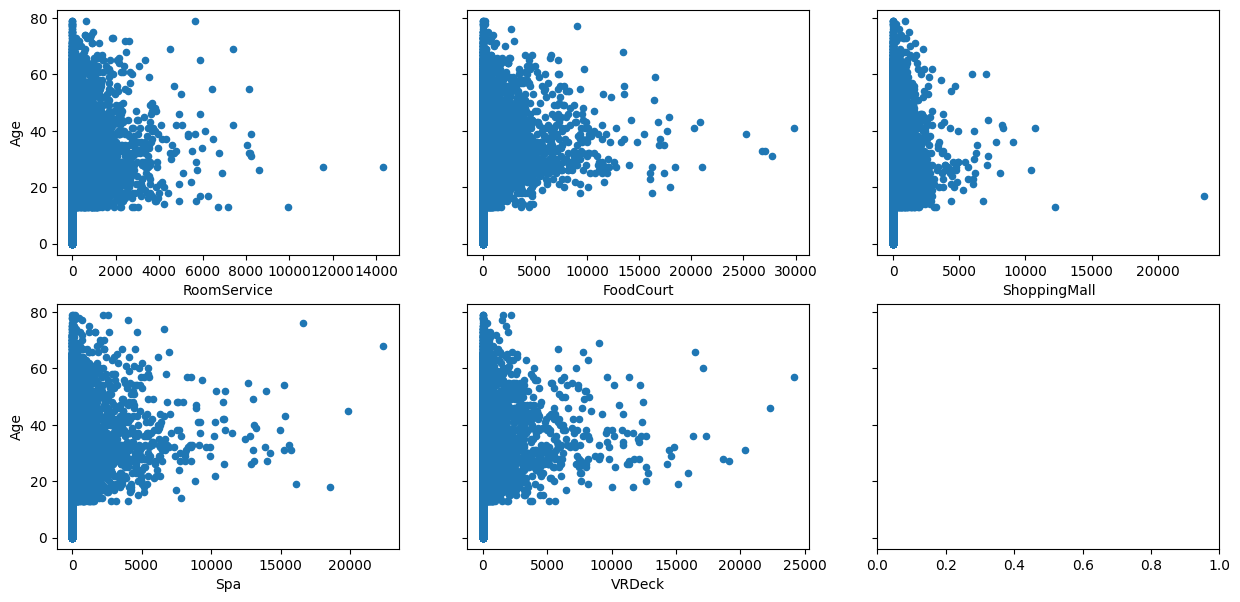

In [136]:
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(15, 7))
df.plot.scatter(x='RoomService', y='Age', ax=axes[0, 0])
df.plot.scatter(x='FoodCourt', y='Age', ax=axes[0, 1])
df.plot.scatter(x='ShoppingMall', y='Age', ax=axes[0, 2])
df.plot.scatter(x='Spa', y='Age', ax=axes[1, 0])
df.plot.scatter(x='VRDeck', y='Age', ax=axes[1, 1])
plt.show()

In [137]:
# Cap RoomService at 9000
df.loc[df.RoomService.gt(8000), 'RoomService'] = 8000

# Cap FoodCourt at 22000
df.loc[df.FoodCourt.gt(20000), 'FoodCourt'] = 20000

# Cap ShoppingMall at 11000
df.loc[df.ShoppingMall.gt(10000), 'ShoppingMall'] = 10000

# Cap Spa at 17000
df.loc[df.Spa.gt(16000), 'Spa'] = 16000

# Cap VRDeck at 21000
df.loc[df.VRDeck.gt(20000), 'VRDeck'] = 20000

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.gt.html

In [138]:
df.groupby('VIP').Age.min()

VIP
0.0     0.0
1.0    18.0
Name: Age, dtype: float64

<Axes: xlabel='Age', ylabel='VIP'>

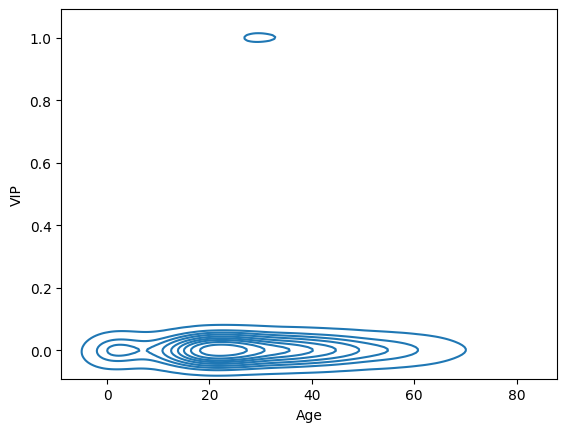

In [139]:

sns.kdeplot(data = df, x = 'Age', y = 'VIP')


In [140]:
len(df.loc[df.Age < 15])

1575

In [141]:
# Vamos começar as análises por HomePlanet

df.groupby(['HomePlanet']).deck.value_counts() 
#df.groupby(['HomePlanet', 'VIP']).deck.value_counts() #nada interessante

HomePlanet  deck
Earth       G       3700
            F       2426
            E        583
Europa      B       1124
            C       1081
            A        346
            D        296
            E        197
            T         10
Mars        F       1713
            E        508
            D        406
Name: deck, dtype: int64

- Decks *G* só transportam pessoas da terra
- Terra só possui decks *G*, *E*, *F*
- Deck *T* só sai de Europa
- Europa só possui decks *A*, *B*, *C*, *D*, *E* e *T*
- Europa só possui decks *D*, *E* e *F*

In [142]:
df.loc[df.deck == 'G', 'HomePlanet' ] = 'Eart'
df.loc[df.deck == 'T', 'HomePlanet' ] = 'Europe'

In [143]:
#df.groupby(['HomePlanet','CryoSleep']).deck.value_counts() # nada de interessante
df.groupby(['VIP',]).deck.value_counts() # nada de interessante


VIP  deck
0.0  F       4102
     G       3693
     E       1274
     B       1058
     C       1018
     D        666
     A        299
     T         10
1.0  B         58
     C         55
     A         45
     D         41
     F         41
     E         26
Name: deck, dtype: int64

- Só temos VIPs nos terminais A, B, C, D, E
- Terminais F, G e T não possuem vips

In [144]:
df.loc[(df.deck == 'F') | (df.deck == 'G') | (df.deck == 'T'), 'VIP' ] = 0
df.loc[(df.deck == 'A') | (df.deck == 'B') | (df.deck == 'C') | (df.deck == 'D') | (df.deck == 'E'), 'VIP' ] = 1

In [145]:
df.groupby(['CryoSleep', 'HomePlanet','Destination']).deck.value_counts() # nada de interessante

CryoSleep  HomePlanet  Destination    deck
0.0        Eart        55 Cancri e    G        230
                       PSO J318.5-22  G        161
                       TRAPPIST-1e    G       1236
           Earth       55 Cancri e    F        362
                                      E         63
                       PSO J318.5-22  F        300
                                      E         40
                       TRAPPIST-1e    F       1639
                                      E        431
           Europa      55 Cancri e    C        219
                                      B        198
                                      A        101
                                      D         51
                                      E         34
                       PSO J318.5-22  C          8
                                      B          3
                                      A          1
                       TRAPPIST-1e    C        363
                                      B

- Deck T não transporta  CryoSleep
- A qtd de pessoas que saem com CryoSleep da terra nos decks E e F são mínimas
- Mars -> PSO, Deck D somente SEM Cryo

In [146]:
df.loc[(df.deck == 'T') , 'CryoSleep' ] = 0
df.loc[((df.CryoSleep == 1) & (df.deck == 'E')) | ((df.CryoSleep == 1) & (df.deck == 'F')), 'deck' ] = 'G'
df.loc[(df.HomePlanet == 'Mars') & (df.Destination == 'PSO J318.5-22') & (df.deck == 'D') , 'CryoSleep' ] = 0

JOGANDO O NOSSO DF ATUALIZADO PARA DENTRO DO ML

In [147]:
X_novo = df.loc[df.PassengerId.isin(train_pass_id)]
X_novo.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,deck,num,side,Passenger,_Id
0,0001_01,Europa,0.0,TRAPPIST-1e,39.0,1.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,B,0,P,0001,01
1,0002_01,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,F,0,S,0002,01
2,0003_01,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,A,0,S,0003,01
3,0003_02,Europa,0.0,TRAPPIST-1e,33.0,1.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,A,0,S,0003,02
4,0004_01,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,F,1,S,0004,01


In [162]:
X_novo['num'] = pd.to_numeric(X_novo['num'])
X_novo['_Id'] = pd.to_numeric(X_novo['_Id'])
X_novo.drop(columns = ['PassengerId', 'Passenger', 'Name'], inplace = True)

C:\Users\andre\AppData\Local\Temp\ipykernel_1912\1007149998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_novo['num'] = pd.to_numeric(X_novo['num'])
C:\Users\andre\AppData\Local\Temp\ipykernel_1912\1007149998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_novo['_Id'] = pd.to_numeric(X_novo['_Id'])
C:\Users\andre\AppData\Local\Temp\ipykernel_1912\1007149998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

In [ ]:
# separando os valores de cabine
X[['deck', 'num', 'side']] = X['Cabin'].str.split(pat = '/', expand = True)
X.drop(columns = 'Cabin', inplace = True)


#substiutior os False and Trues por 0 e 1
X.replace({ False : 0,
                 True: 1}, inplace = True)

y.replace({ False : 0,
                 True: 1}, inplace = True)

# em uma primeira abordagem, vamos substituir todos os NaN pelos valores mais frequentes
# será ralizado dentro de um dataframe
X['num'] = pd.to_numeric(X['num'])

## Tive que remover as duas colunas abaixo pois estavam apresentando problemas no pipeline, depois vou investigar, mas acredito que deva ser por causa do inputer.
X.drop(columns = ['PassengerId', 'Name'], inplace = True)



# separando as colunas entre numéricas e categóricas
colunas_numericas = X.select_dtypes(include=np.number).columns
colunas_numericas

colunas_categoricas = X.select_dtypes(include = 'object').columns
colunas_categoricas


In [164]:
colunas_numericas = X_novo.select_dtypes(include=np.number).columns
colunas_numericas

colunas_categoricas = X_novo.select_dtypes(include = 'object').columns
colunas_categoricas


Index(['HomePlanet', 'Destination', 'deck', 'side'], dtype='object')

# Estrutura do pipeline

In [153]:
# Preprocessamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm



In [165]:
#Split de treino e teste
SEED = 123
X_train, X_test, y_train, y_test = train_test_split(X_novo, y, test_size=0.3, random_state=SEED)

#preprocessor
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='most_frequent'))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='most_frequent'))
      ,('encoder', OneHotEncoder()) #depois testar com OrdinalEncoder
])



numeric_features = colunas_numericas 
categorical_features = colunas_categoricas

preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
]) 

In [166]:
#Estruturando os pipelines


pipe_lr = Pipeline([('preprocessor', preprocessor),
                    ('LR', LogisticRegression(random_state = SEED))])
pipe_dt = Pipeline([('preprocessor', preprocessor),
                    ('DT',DecisionTreeClassifier(random_state = SEED))])
pipe_rf = Pipeline([('preprocessor', preprocessor),
                    ('RF',RandomForestClassifier(random_state = SEED))])
pipe_knn = Pipeline([('preprocessor', preprocessor),
                    ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([('preprocessor', preprocessor),
                     ('SVM', svm.SVC(random_state = SEED))])
pipe_xgb = Pipeline([('preprocessor', preprocessor),
                     ('XGB', XGBClassifier(random_state = SEED))])

In [167]:
pipelines = [pipe_lr, pipe_dt, pipe_rf, pipe_knn, pipe_svm, pipe_xgb]
for pipe in pipelines:
  pipe.fit(X_train, y_train.values.ravel())

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [170]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines', 5: 'XGBoost'}
for i, model in enumerate(pipelines):
    print('{} Test Accuracy: {}'.format(grid_dict[i], model.score(X_test,y_test)))
    #print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

Logistic Regression Test Accuracy: 0.8040644171779141
Decision Trees Test Accuracy: 0.7446319018404908
Random Forest Test Accuracy: 0.8101993865030674
K-Nearest Neighbors Test Accuracy: 0.7944785276073619
Support Vector Machines Test Accuracy: 0.8136503067484663
XGBoost Test Accuracy: 0.8094325153374233


In [171]:
## Gerando o CSV de submissão:
# realizando as mudanças que fizemos no dataset original FORA do pipeline:

test = df.loc[df.PassengerId.isin(test_pass_id)]

# gerando o modelo
svm_model = pipe_svm.fit(X_train, y_train)

# gerando y_previsto
y_previsto = svm_model.predict(test) 
y_previsto

c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [172]:
# Save predictions in the format used for competition scoring
output = pd.DataFrame({'PassengerId': test_pass_id,
                       'Transported': y_previsto.astype(bool)})

output.to_csv('submission.csv', index=False)